### Práctica: Modelado del sistema de temperatura LTR701 (modelo de primer orden).

**Objetivo:**
Obtener el modelo de la Función de Transferencia (FT) del sistema de temperatura LTR701, utilizando el método de la curva de reacción. El modelo a obtener es el de **Primer Orden más Tiempo Muerto (FOPDT)**, que tiene la siguiente estructura:

$$G_p(s) = \frac{K \cdot e^{-Ls}}{Ts + 1}$$

---

#### Materiales.

* Planta de control de temperatura LTR701.
* Microcontrolador (Se recomienda Arduino UNO, pero es a su preferencia).
* Computadora con Arduino IDE.
* Osciloscopio con función de guardado en pantalla.
* Memoria USB (formato FAT32) para el osciloscopio.
* Cables de conexión (tipo banana, jumpers, cable USB).

---

#### Paso 1. Configuración del hardware.

1.  **Conexiones:**
    * Conecte la salida de PWM del Arduino a la entrada de control del actuador (calefactor) del LTR701.
    * Conecte la salida analógica del sensor de temperatura del LTR701 a una entrada analógica del Arduino.
    * Conecte la sonda del Canal 1 (CH1) del osciloscopio a la misma salida del sensor de temperatura.
    * Asegúrese de que todas las tierras (GND) estén conectadas (Arduino, LTR701, sonda del osciloscopio).

2.  **Configuración LTR701:**
    * Encienda el sistema LTR701.
    * Configure el extractor de aire a una potencia del 10% para que opere el sistema.


---

#### Paso 2. Configuración del software (Arduino).

Cargue el siguiente código en su Arduino. Este código inicializa el PWM al 20%, espera una entrada por el monitor serie para aplicar el escalón al 40%, y envía constantemente los datos de tiempo y temperatura.

```
const int PWM_PIN = 9;   // Pin de salida PWM (actuador).
const int TEMP_PIN = A0; // Pin de entrada analógica (sensor).

// Ciclos de trabajo (0-255).
// 20% de 255 = 51
// 40% de 255 = 102
int pwm_ss1 = 51;
int pwm_ss2 = 102;

//Bandera que indica si se ha aplicado el escalón
bool is_step_applied = false;

void setup() {
  Serial.begin(115200);
  pinMode(PWM_PIN, OUTPUT);

  // Iniciar en el primer estado estacionario (20% PWM).
  analogWrite(PWM_PIN, pwm_ss1);

  Serial.println("Sistema en 20% PWM. Esperando estabilización...");
  Serial.println("Escriba 'step' y presione Enter para aplicar el escalón al 40%.");
}

void loop() {
  // Verificar si el usuario ha enviado el comando 'step'.
  if (Serial.available() > 0) {
    String cmd = Serial.readStringUntil('\n');

    // Aplicar escalón al 40% la primera vez que se indica el comando.
    if (cmd == "step" && !is_step_applied) {
      analogWrite(PWM_PIN, pwm_ss2); 
      is_step_applied = true;
      Serial.println("--- ESCALÓN APLICADO (40%) ---");
    }
  }

  // Leer y enviar datos (Tiempo (ms), ValorADC (0-1023))
  long tiempo = millis();
  int voltaje_temp_adc = analogRead(TEMP_PIN);

  Serial.print(tiempo);
  Serial.print(",");
  Serial.println(voltaje_temp_adc);

  delay(200); // Muestrear 5 veces por segundo
}

```

---

#### Paso 3. Ejecución de la prueba y captura de datos.

1.  **Alcanzar SS1:** 
    * Ejecute el código. 
    * Observe el Monitor Serie del Arduino. 
    * Deje el sistema funcionando al 20% de PWM hasta que el valor de temperatura sea estable (**Estado estacionario 1 (SS1)** ).

2.  **Configurar Captura:**
    * **Osciloscopio:**
        * Ajuste el acoplamiento a DC.
        * Ajuste la escala vertical (Volts/div) para que la señal de SS1 (ej. 2.0 V) esté en la parte inferior de la pantalla y haya espacio para que suba.
        * Ajuste la base de tiempo (Seg/div) para capturar un periodo largo (ej. 10 seg/div).
        * Configure el modo de disparo (Trigger) en "Single Shot" o "Normal", con el nivel de disparo justo por encima del voltaje de SS1.
    * **Arduino (PC):**
        * Abra el Monitor Serie (Herramientas -> Monitor Serie).

3.  **Aplicar Escalón:** Escriba `step` en el Monitor Serie y presione Enter. El PWM cambiará al 40%.

4.  **Capturar Curva S:**
    * **Osciloscopio:** El disparo se activará y el osciloscopio capturará la curva completa. Espere hasta que la temperatura se estabilice en el **Estado Estacionario 2 (SS2)**. Utilice la función "Guardar Imagen" o "Guardar Captura" en la memoria USB.
    * **Arduino (PC):** Deje el monitor serie registrando datos hasta que se alcance SS2. Copie toda la salida de texto (desde antes del escalón hasta el final) y péguela en un archivo de texto llamado `datos_curva_s.txt`.

A continuación, se muestra un ejemplo de la forma de onda que debería obtener:

![Figura 1. Curva S de respuesta al escalón (ejemplo).](../assets/images/P_3_01_Curva_s.png)

*Figura 1. Curva S de respuesta al escalón (ejemplo del manual).*


---

En las figuras 2 y 3 se muestra la forma de onda obtenida por el osciloscopio y mediante los datos graficados del Arduino:
![Figura 2. Curva S de respuesta al escalón (osciloscopio).](../assets/images/TEK0006.png)

*Figura 2. Curva S de respuesta al escalón (osciloscopio).*


![Figura 3. Curva S de respuesta al escalón (datos de Arduino).](../assets/images/image.png)

*Figura 3. Curva S de respuesta al escalón (datos de Arduino).*

Ahora tiene dos conjuntos de datos que representan la misma curva S: una imagen del osciloscopio y un archivo de texto del Arduino.

---

#### Paso 4. Determinación de $K$ (Ganancia del sistema de temperatura LTR701).

La ganancia $K$ es la relación entre el cambio en la salida ($\Delta y$) y el cambio en la entrada ($\Delta u$).

$$K = \frac{\Delta y}{\Delta u}$$

**¿Por qué este cociente?**

La ganancia $K$ nos dice "cuánto" cambia la salida por cada unidad que cambia la entrada, asumiendo una relación lineal.

* **$\Delta y$ (Cambio en Salida):** No medimos desde 0°C, sino desde el valor estable inicial ($y_{SS1}$ o $T_{estable@20\%}$). Medimos el incremento total de temperatura hasta el nuevo valor estable ($y_{SS2}$ o $T_{final@40\%}$). Por lo tanto, $\Delta y = y_{SS2} - y_{SS1}$.
* **$\Delta u$ (Cambio en Entrada):** No aplicamos el escalón desde 0%, sino desde 20% hasta 40%. Hacemos esto para evitar la "inercia de arranque en frío" del calefactor, obteniendo una respuesta más precisa de cómo se comporta el sistema cuando ya está en operación, que es como funcionará el controlador PID.

**Cálculo:**

* **$\Delta u$ (cambio de la entrada considerando valores promedio):**
    Asumiendo que el PWM del Arduino es de 0-5V:
    * $u_{inicial}$ (20%) = $0.20 \times 5V = 1.0 V$
    * $u_{final}$ (40%) = $0.40 \times 5V = 2.0 V$
    * **$\Delta u = 2.0V - 1.0V = 1.0 V$**

* **$\Delta y$ (cambio del voltaje de salida):**
    Mida los valores de voltaje (o temperatura) de los dos estados estacionarios en sus datos.
    * $y_{SS1}$ = Valor estable antes del escalón (ej. 2.500 V).
    * $y_{SS2}$ = Valor estable final (ej. 3.025 V).
    * **$\Delta y = y_{SS2} - y_{SS1}$**. Ejemplo: $3.030V - 2.500V = 0.53 V$.

* **Cálculo de K (ejemplo):**

    $$K = \frac{0.53 V}{1.0 V} = 0.53$$

---

#### Paso 5. Determinación de $L$ y $T$ (Método del Punto de Inflexión).

Debemos encontrar el punto de inflexión de la curva S (donde la pendiente es máxima) y trazar una línea tangente.

* **Método A: Análisis con osciloscopio (gráficamente).**
1.  Observe la captura de pantalla de su osciloscopio.
2.  Use las herramientas de **cursores** del osciloscopio para trazar una línea tangente visual en el **punto de inflexión** (la parte más recta de la curva S).
3.  Ajuste los cursores de tiempo (X) y voltaje (Y) para medir:
    * **$L$ (Tiempo Muerto):** Mida el tiempo desde que se aplicó el escalón ($t_0$) hasta que la línea tangente cruza la línea de base **$y_{SS1}$**.
    * **$T$ (Constante de Tiempo):** Mida el tiempo que tarda la línea tangente en ir desde **$y_{SS1}$** hasta **$y_{SS2}$**.


* **Método B: Análisis con datos del arduino (derivada filtrada). Utilice el script de Python a continuación que realiza lo siguiente:**
1.  Importa sus datos (Tiempo, ValorADC) del archivo `datos_curva_s.txt`.
2.  Convierte los valores ADC a Voltaje (Voltaje = ValorADC * 5.0 / 1023.0).
3.  Aplica un filtro para la señal.
3.  Calcula la derivada ($\Delta y / \Delta t$) entre cada punto.
4.  Encuentra el valor **máximo** de esta derivada. Ese es el punto de inflexión, en donde:
    * $m$ es el valor de la derivada máxima.
    * $t_{inflexion}$ es el tiempo en el que ocurre $m$.
    * $y_{inflexion}$ es el valor de voltaje en $t_{inflexion}$.
5.  **Calcula $L$ y $T$:**
    * $t_L = t_{inflexion} + \frac{y_{SS1} - y_{inflexion}}{m}$
    * $t_T = t_{inflexion} + \frac{y_{SS2} - y_{inflexion}}{m}$
    * **$L$ (Tiempo Muerto) = $t_L - t_0$** (donde $t_0$ es el tiempo en que aplicó el escalón).
    * **$T$ (Constante de Tiempo) = $t_T - t_L$**

---

--- Método B: Análisis---

Parámetros de inflexión:
  Derivada máxima (m)         = 0.0267 V/s
  Tiempo de inflexión (t_inf) = 59.16 s
  Voltaje de inflexión (y_inf) = 3.708 V

Tiempos calculados (método de la tangente):
  t_L (intersección inferior) = 57.57 s
  t_T (intersección superior) = 67.23 s

--- PARÁMETROS FOPDT OBTENIDOS ---
  K = 0.258
  L = 2.217 s
  T = 9.661 s


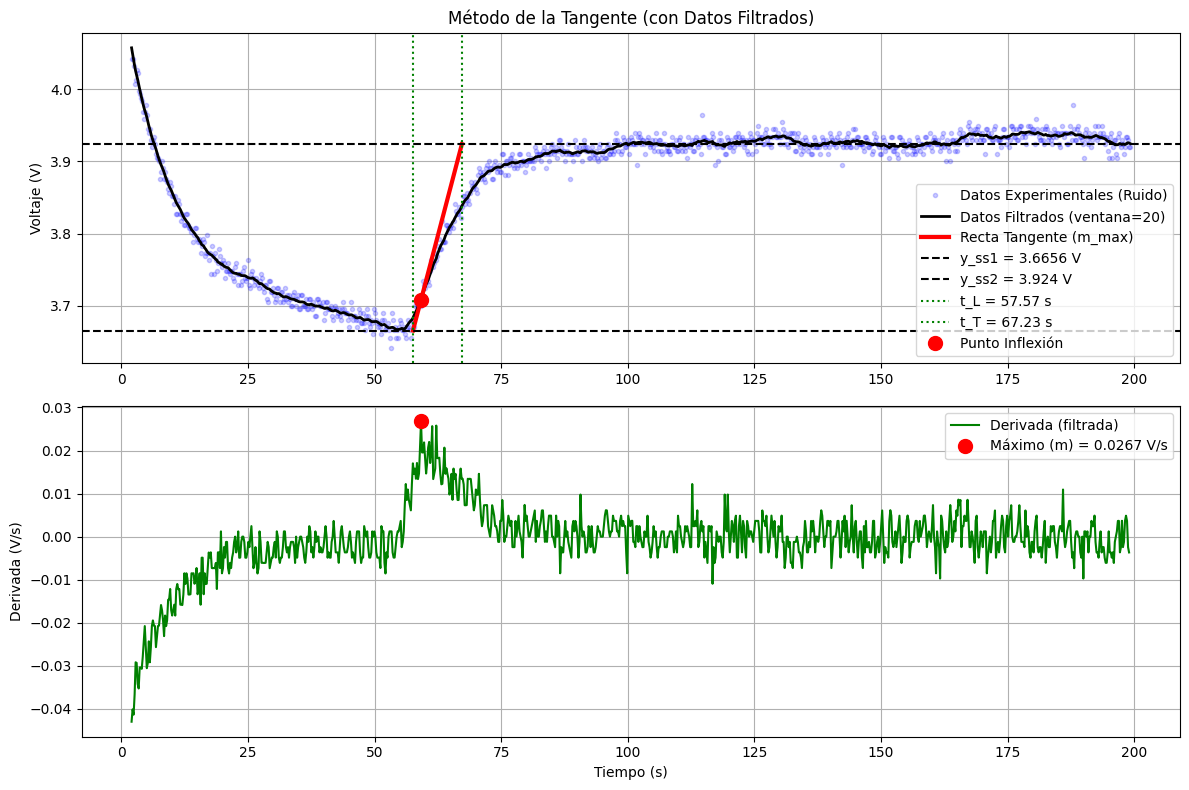

In [12]:
# Código PARA EL MÉTODO B.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


# --- Nombre del archivo (debe estar en la misma carpeta de este script) ---
nombre_archivo = 'datos_curva_s.txt'

# --- Parámetros del experimento (REEMPLAZAR CON SUS VALORES) ---
y_ss1 = 3.6656     # Voltaje de estado estacionario inicia.
y_ss2 = 3.924   # Voltaje de estado estacionario final.
delta_u = 1.0    # Cambio en la entrada.

# --- Tiempo del escalón (REEMPLAZAR CON SUS VALORES) ---
# Es el primer valor de tiempo que el Monitor Serie imprime inmediatamente después de que aparece el mensaje --- ESCALÓN APLICADO (40%) ---
t_0 = 55.35      # Nota: Convertir el valor de ms a segundos.

# --- Ventana del filtro  (Puedes ajustar este valor si es necesario, 5 o 7 es un buen inicio) ---
window_size = 20


try:
    # --- 1. Importar datos (Tiempo, ValorADC) ---
    # Usamos pandas para cargar, luego convertimos a NumPy.
    data = pd.read_csv(nombre_archivo, header=None, names=['Tiempo_ms', 'Valor_ADC'])
    
 
    # --- 2. Convertir ADC a Voltaje y aplica el filtro ---   
    # Convertir a Series de pandas
    data['t_seg'] = data['Tiempo_ms'] / 1000.0
    data['y_voltaje_ruido'] = data['Valor_ADC'] * (5.0 / 1023.0)

    # Aplicar un filtro de media móvil para suavizar el ruido
    data['y_voltaje_filtrado'] = data['y_voltaje_ruido'].rolling(window=window_size, center=True).mean()
    
    # Descartar las filas con NaN (generadas en los bordes por el filtro)
    data = data.dropna()
    
    # Ahora convertir a arrays de NumPy para los cálculos
    t_seg = data['t_seg'].to_numpy()
    y_voltaje_ruido = data['y_voltaje_ruido'].to_numpy()       # Voltaje original
    y_voltaje_filtrado = data['y_voltaje_filtrado'].to_numpy() # Voltaje filtrado
    

    # --- 3. Calcular la derivada sobre datos filtrados ---
    # np.diff() calcula la diferencia entre elementos consecutivos (ej. y[1]-y[0])
    dy = np.diff(y_voltaje_filtrado)
    dt = np.diff(t_seg)
    
    # Evitar división por cero si el tiempo entre muestras es 0 al asignar un valor muy pequeño
    dt[dt == 0] = 1e-9
    
    derivada = dy / dt
    
    # El array 'derivada' tiene N-1 elementos.
    # Asociamos la derivada[i] al tiempo[i] (el inicio del intervalo)
    t_derivada = t_seg[:-1] # Todos los tiempos excepto el último


    # --- 4. Encontrar el punto de inflexión (derivada máxima) ---
    m = np.max(derivada)            # (m) Valor de la derivada máxima
    idx_max = np.argmax(derivada)   # Índice (posición) donde ocurre el máximo
    
    t_inflexion = t_derivada[idx_max] # Tiempo en el que ocurre m
    
    y_inflexion = y_voltaje_filtrado[idx_max]


    # --- 5. Calcular L y T analíticamente (Método de Ziegler-Nichols) ---
    # Calcular las intersecciones de la recta tangente
    t_L = t_inflexion + (y_ss1 - y_inflexion) / m
    t_T = t_inflexion + (y_ss2 - y_inflexion) / m
    
    # Calcular los parámetros L y T
    L = t_L - t_0
    T = t_T - t_L
    
    # Calcular la Ganancia K
    K = (y_ss2 - y_ss1) / delta_u

    # --- 6. Impresión de Resultados ---
    print(f"--- Método B: Análisis---")
    
    print("\nParámetros de inflexión:")
    print(f"  Derivada máxima (m)         = {m:.4f} V/s")
    print(f"  Tiempo de inflexión (t_inf) = {t_inflexion:.2f} s")
    print(f"  Voltaje de inflexión (y_inf) = {y_inflexion:.3f} V")
    
    print("\nTiempos calculados (método de la tangente):")
    print(f"  t_L (intersección inferior) = {t_L:.2f} s")
    print(f"  t_T (intersección superior) = {t_T:.2f} s")

    print("\n--- PARÁMETROS FOPDT OBTENIDOS ---")
    print(f"  K = {K:.3f}")
    print(f"  L = {L:.3f} s")
    print(f"  T = {T:.3f} s")


    # --- 7. Visualización en la gráfica. ---
    # Calcular la línea tangente para graficarla
    b_tangente = y_inflexion - m * t_inflexion
    t_graf_tangente = np.array([t_L, t_T])
    y_graf_tangente = m * t_graf_tangente + b_tangente

    plt.figure(figsize=(12, 8))
    
    # Gráfica 1: Datos y Tangente
    # Graficamos los datos originales (con ruido) Y los datos filtrados
    ax1 = plt.subplot(2, 1, 1)
    ax1.plot(t_seg, y_voltaje_ruido, 'b.', label='Datos Experimentales (Ruido)', alpha=0.2)
    ax1.plot(t_seg, y_voltaje_filtrado, 'k-', linewidth=2, label=f'Datos Filtrados (ventana={window_size})')
    
    ax1.plot(t_graf_tangente, y_graf_tangente, 'r-', linewidth=3, label='Recta Tangente (m_max)')
    ax1.axhline(y=y_ss1, color='k', linestyle='--', label=f'y_ss1 = {y_ss1} V')
    ax1.axhline(y=y_ss2, color='k', linestyle='--', label=f'y_ss2 = {y_ss2} V')
    ax1.axvline(x=t_L, color='g', linestyle=':', label=f't_L = {t_L:.2f} s')
    ax1.axvline(x=t_T, color='g', linestyle=':', label=f't_T = {t_T:.2f} s')
    ax1.plot(t_inflexion, y_inflexion, 'ro', markersize=10, label='Punto Inflexión')
    
    ax1.set_title('Método de la Tangente (con Datos Filtrados)')
    ax1.set_ylabel('Voltaje (V)')
    ax1.legend()
    ax1.grid(True)

    # Gráfica 2: Derivada
    ax2 = plt.subplot(2, 1, 2, sharex=ax1)
    ax2.plot(t_derivada, derivada, 'g-', label='Derivada (filtrada)') 
    ax2.plot(t_inflexion, m, 'ro', markersize=10, label=f'Máximo (m) = {m:.4f} V/s')
    ax2.set_xlabel('Tiempo (s)')
    ax2.set_ylabel('Derivada (V/s)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()


except FileNotFoundError:
    print(f"Error: No se encontró el archivo '{nombre_archivo}'")
    print("Por favor, asegúrese que el archivo .txt está en la misma carpeta que el script.")
    
except Exception as e:
    print(f"Ha ocurrido un error inesperado: {e}")
    

#### Paso 6. Obtención de la Función de Transferencia.

Con los valores que calculó (ejemplo):

* $K$ = 0.258
* $L$ = 2.217  s
* $T$ = 9.661 s

La función de transferencia de su planta LTR701 es:

$$G_p(s) = \frac{K \cdot e^{-Ls}}{Ts + 1}$$

$$G_p(s) = \frac{0.258 \cdot e^{-2.217s}}{9.661s + 1}$$

---

#### Paso 7. Comparación del modelo obtenido con la respuesta del sistema.

El paso final es comprobar si su modelo matemático coincide con la realidad. Usaremos Python para graficar la respuesta del modelo de la planta LTR701 obtenido y la superpondremos a los datos experimentales que capturó con el Arduino.


Función de Transferencia del Modelo (FOPDT):
         0.258 * e^(-2.217s)
  G(s) = -----------
         9.661s + 1



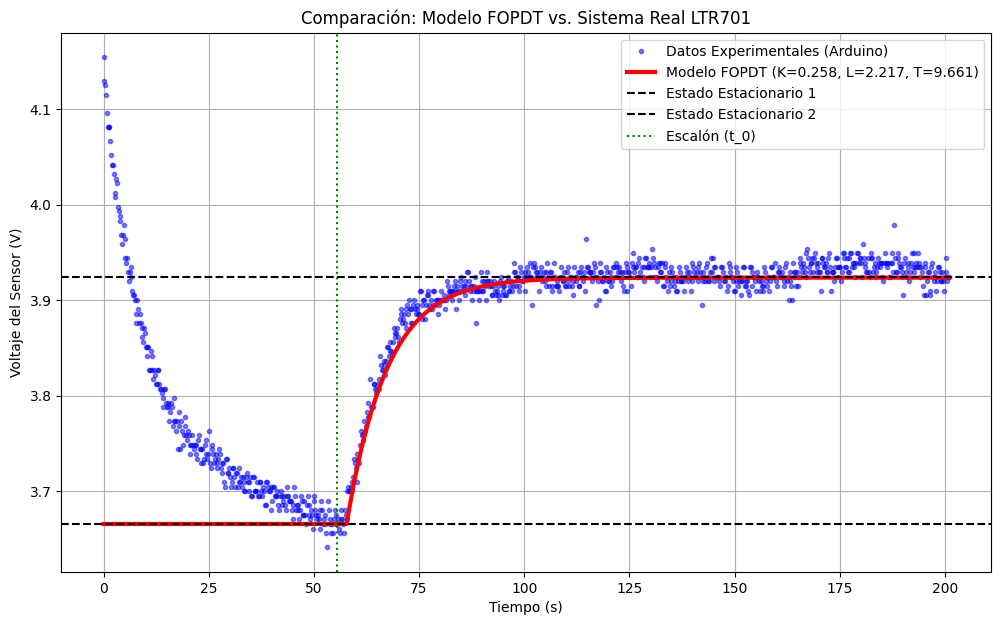

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Parámetros del archivo
nombre_archivo = 'datos_curva_s.txt'

# --- Parámetros obtenidos del análisis (REEMPLAZAR CON SUS VALORES) ---
K = 0.258
L = 2.217     # Tiempo muerto (s)
T = 9.661     # Constante de tiempo (s)
 
# --- Parámetros del experimento (REEMPLAZAR CON SUS VALORES) ---
y_ss1 = 3.6656    # Voltaje de estado estacionario inicia.
y_ss2 = 3.924   # Voltaje de estado estacionario final.
delta_u = 1.0  # Cambio en la entrada.

# --- Tiempo del escalón (REEMPLAZAR CON SUS VALORES) ---
# Es el primer valor de tiempo que el Monitor Serie imprime inmediatamente después de que aparece el mensaje --- ESCALÓN APLICADO (40%) ---
t_in = 55.35      # Nota: Convertir el valor de ms a segundos.

# --- Definir e imprimir la Función de Transferencia (FT) ---
print("\n" + "="*40)
print("Función de Transferencia del Modelo (FOPDT):")
print(f"         {K} * e^(-{L}s)")
print(f"  G(s) = {'-' * (len(str(T)) + 6)}")
print(f"         {T}s + 1")
print("="*40 + "\n")


try:
    # Cargar datos del Arduino (Tiempo en ms, Valor ADC)
    data = pd.read_csv(nombre_archivo, header=None, names=['Tiempo_ms', 'Valor_ADC'])
    
    # Convertir a segundos y voltaje
    t_exp = data['Tiempo_ms'] / 1000.0
    y_exp = data['Valor_ADC'] * (5.0 / 1023.0) # Convertir ADC a Voltaje
    

    t_0 = t_exp[t_exp > t_in].iloc[0] # Encuentra el tiempo del escalón (ej. 50s)

    # --- Crear la respuesta del modelo FOPDT ---
    t_sim = t_exp.copy()
    y_sim = np.zeros_like(t_sim)

    for i, t in enumerate(t_sim):
        if t < (t_0 + L):
            y_sim[i] = y_ss1
        else:
            # Ecuación de respuesta al escalón de un FOPDT
            # y = y_inicial + (Ganancia_Total) * (1 - e^(-(t - t_escalon - L) / T))
            y_sim[i] = y_ss1 + (K * delta_u) * (1 - np.exp(-(t - t_0 - L) / T))
            
            # Limitar la respuesta al valor final por si el modelo sobrepasa
            if y_sim[i] > y_ss2:
                y_sim[i] = y_ss2

    # --- Graficar la comparación ---
    plt.figure(figsize=(12, 7))
    plt.plot(t_exp, y_exp, 'b.', label='Datos Experimentales (Arduino)', alpha=0.5)
    plt.plot(t_sim, y_sim, 'r-', linewidth=3, label=f'Modelo FOPDT (K={K:.3f}, L={L:.3f}, T={T:.3f})')
    plt.axhline(y=y_ss1, color='k', linestyle='--', label='Estado Estacionario 1')
    plt.axhline(y=y_ss2, color='k', linestyle='--', label='Estado Estacionario 2')
    plt.axvline(x=t_0, color='g', linestyle=':', label='Escalón (t_0)')
    
    plt.title('Comparación: Modelo FOPDT vs. Sistema Real LTR701')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Voltaje del Sensor (V)')
    plt.legend()
    plt.grid(True)
    plt.show()

except FileNotFoundError:
    print(f"Error: No se encontró el archivo {nombre_archivo}")
    print("Por favor, guarde sus datos del Arduino con ese nombre en la misma carpeta.")

#### Conclusión

Si la línea roja (Modelo FOPDT) se superpone bien con los puntos azules (datos experimentales), su identificación ha sido exitosa y la Función de Transferencia obtenida representa fielmente la dinámica de su planta LTR701 para este punto de operación.